In [8]:
from dotenv import load_dotenv
from IPython.display import display, HTML, Image
import os
from openai import AzureOpenAI
import json

load_dotenv()
GPT4o_API_KEY = os.getenv("GPT4o_API_KEY")
GPT4o_DEPLOYMENT_ENDPOINT = os.getenv("GPT4o_DEPLOYMENT_ENDPOINT")
GPT4o_DEPLOYMENT_NAME = os.getenv("GPT4o_DEPLOYMENT_NAME")



client = AzureOpenAI(
  azure_endpoint = GPT4o_DEPLOYMENT_ENDPOINT, 
  api_key=GPT4o_API_KEY,  
  api_version="2024-02-15-preview"
)

In [9]:
import inspect

# helper method used to check if the correct arguments are provided to a function
def check_args(function, args):
    sig = inspect.signature(function)
    params = sig.parameters

    # Check if there are extra arguments
    for name in args:
        if name not in params:
            return False
    # Check if the required arguments are provided
    for name, param in params.items():
        if param.default is param.empty and name not in args:
            return False

    return True

In [10]:
# Defining the functions - in this case a toy example of a shipping function

def send_to_database(numeroDeCompteur,indexConsummation):
     return f"Envoi en base de données des compteurs : compteur: {numeroDeCompteur}, index: {indexConsummation}"

def send_for_human_analysis(numeroDeCompteur,indexConsummation):
     return f"Envoi pour traitement manuel du compteur: {numeroDeCompteur}, index: {indexConsummation}"


    

In [11]:
# Defining the available functions and their metadata to send to GPT-4-O
tools = [
    {
        "type": "function",
        "function": {
            "name": "send_to_database",
            "description": "Send successful extracted infos to the database",
            "parameters": {
                "type": "object",
                "properties": {
                    "numeroDeCompteur": {
                        "type": "string",
                        "description": "The counter identifier",
                    },
                    "indexConsummation": {
                        "type": "string",
                        "description": "The user consumption index",
                    }
                },
                "required": ["numeroDeCompteur", "indexConsummation"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "send_for_human_analysis",
            "description": "Send unsuccessful extracted infos to human analysis.",
            "parameters": {
                "type": "object",
                "properties": {
                    "numeroDeCompteur": {
                        "type": "string",
                        "description": "The counter identifier",
                    },
                    "indexConsummation": {
                        "type": "string",
                        "description": "The user consumption index",
                    }
                },
                "required": ["numeroDeCompteur", "indexConsummation"],
            },
        },
    },
]

available_functions = {
    "send_to_database": send_to_database,
    "send_for_human_analysis": send_for_human_analysis,
}

In [12]:
# Encoding the images to send to GPT-4-O
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


In [13]:
def call_OpenAI(messages, tools, available_functions):
    # Step 1: send the prompt and available functions to GPT
    response = client.chat.completions.create(
        model=GPT4o_DEPLOYMENT_NAME,
        messages=messages,
        tools=tools,
        tool_choice="auto",
    )

    response_message = response.choices[0].message
    print("Response Message:")
    print(response_message)

    # Step 2: check if GPT wanted to call a function
    if response_message.tool_calls:
        print("Recommended Function call:")
        print(response_message.tool_calls[0])
        print()

        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        function_name = response_message.tool_calls[0].function.name

        # verify function exists
        if function_name not in available_functions:
            return "Function " + function_name + " does not exist"
        function_to_call = available_functions[function_name]

        # verify function has correct number of arguments
        function_args = json.loads(response_message.tool_calls[0].function.arguments)
        if check_args(function_to_call, function_args) is False:
            return "Invalid number of arguments for function: " + function_name
        # call the function
        function_response = function_to_call(**function_args)
        print("Output of function call:")
        print(function_response)
        print()



#version with user validation before calling the functions
def call_OpenAI(messages, tools, available_functions):
    # Step 1: send the prompt and available functions to GPT
    response = client.chat.completions.create(
        model=GPT4o_DEPLOYMENT_NAME,
        messages=messages,
        tools=tools,
        tool_choice="auto",
    )

    response_message = response.choices[0].message
    print("Response Message:")
    print(response_message)

    # Step 2: check if GPT wanted to call a function
    if response_message.tool_calls:
        print("Recommended Function call:")
        print(response_message.tool_calls[0])
        print()

        # Step 3: validate user input
        function_name = response_message.tool_calls[0].function.name

        # verify function exists
        if function_name not in available_functions:
            return "Function " + function_name + " does not exist"
        function_to_call = available_functions[function_name]

        # verify function has correct number of arguments
        function_args = json.loads(response_message.tool_calls[0].function.arguments)
        if check_args(function_to_call, function_args) is False:
            return "Invalid number of arguments for function: " + function_name

        # Step 4: User validation for each argument
        for arg in function_args:
            user_input = input(f"Press Enter to validate the argument {arg} = {function_args[arg]}, or type a new value: ")
            if user_input.lower() != "":
                new_value = input(f"Please enter a new value for {arg}: ")
                function_args[arg] = new_value

        # Step 5: call the function
        function_response = function_to_call(**function_args)
        print("Output of function call:")
        print(function_response)
        print()


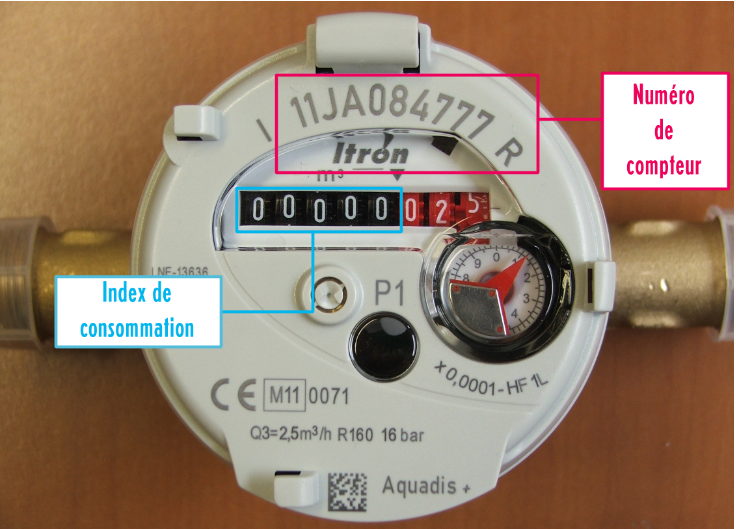

Response Message:
ChatCompletionMessage(content='', role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_QR7eP9RVM9qJPj09JMYqIKQT', function=Function(arguments='{"numeroDeCompteur": "1JA084777R", "indexConsummation": "00000"}', name='send_to_database'), type='function')])
Recommended Function call:
ChatCompletionMessageToolCall(id='call_QR7eP9RVM9qJPj09JMYqIKQT', function=Function(arguments='{"numeroDeCompteur": "1JA084777R", "indexConsummation": "00000"}', name='send_to_database'), type='function')

Output of function call:
Envoi en base de données des compteurs : compteur: 11JA084777, index: 00000



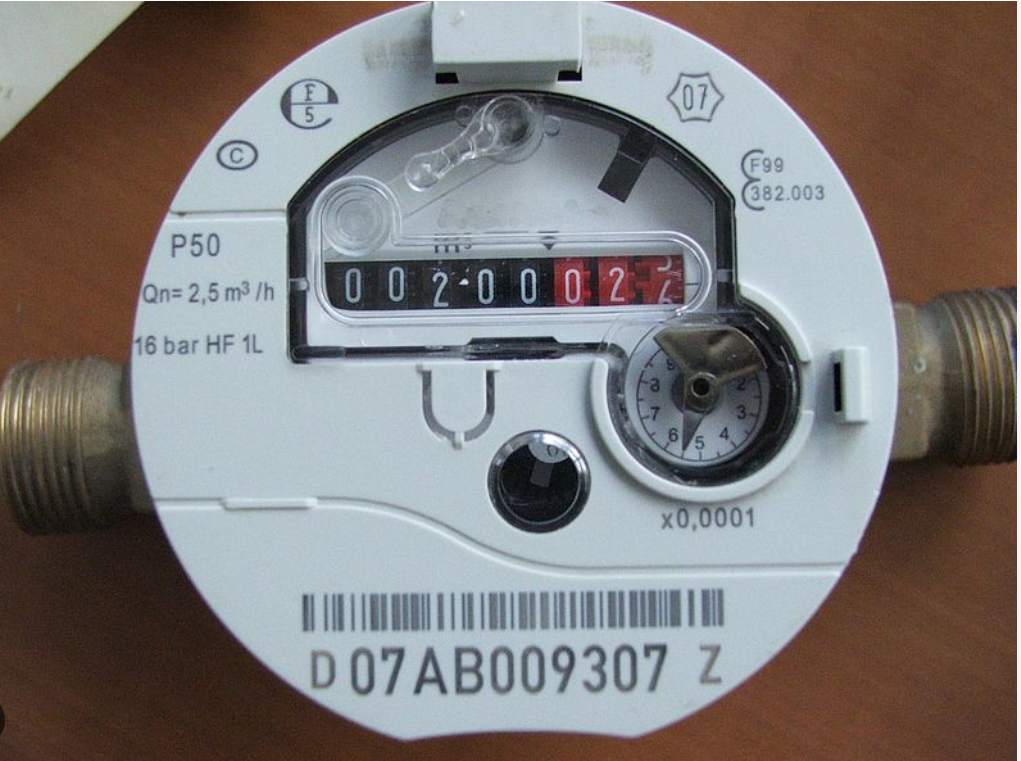

Response Message:
ChatCompletionMessage(content='', role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_ticnUyHrGYRPWT0eF6IlLqH3', function=Function(arguments='{"numeroDeCompteur": "07AB009307", "indexConsummation": "00002"}', name='send_to_database'), type='function')])
Recommended Function call:
ChatCompletionMessageToolCall(id='call_ticnUyHrGYRPWT0eF6IlLqH3', function=Function(arguments='{"numeroDeCompteur": "07AB009307", "indexConsummation": "00002"}', name='send_to_database'), type='function')

Output of function call:
Envoi en base de données des compteurs : compteur: 07AB009307, index: 00200



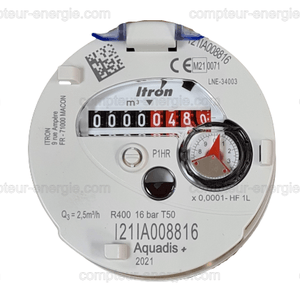

Response Message:
ChatCompletionMessage(content='', role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_qNrZnducsSQD6Scn9lxYaa2R', function=Function(arguments='{"numeroDeCompteur": "21IA008816", "indexConsummation": "00000"}', name='send_to_database'), type='function')])
Recommended Function call:
ChatCompletionMessageToolCall(id='call_qNrZnducsSQD6Scn9lxYaa2R', function=Function(arguments='{"numeroDeCompteur": "21IA008816", "indexConsummation": "00000"}', name='send_to_database'), type='function')

Output of function call:
Envoi en base de données des compteurs : compteur: 21IA008816, index: 00000



In [14]:
# iterate through all the images in the data folder
import os

data_folder = "./data/compteurs"
for image in os.listdir(data_folder):
    if image.endswith(".png"):
        IMAGE_PATH = os.path.join(data_folder, image)
        base64_image = encode_image(IMAGE_PATH)
        display(Image(IMAGE_PATH))
        messages = [
            {"role": "system", "content": """You are a customer service assistant for a water management company, equipped to analyze images of consumption counters (compteurs d'eau). 
            Your job is to extract information from images :
             * numeroDeCompteur (counter number or indentifier) : a 10 alphanumerical number usually on top of the counter , or sometimes at the bottom or side. make sure you pick the right info of 10 chars (for instance for this info : 'D07AB009307 Z' the correct answer is 07AB009307).
             * indexConsummation: usually a 4 or 5 digit numbers with a **black background** AND it has a unit metric of m3. Make sure you extract the 5 digits from the left from this value. (for instance for the captured index info : '00000025' the correct index value is '00000', aka the 5 numbers starting from the left).

             ; If you manage to extract the infos from the image, then save the info to the database, otherwise send it for human review. You must always use tools!"""},
            {"role": "user", "content": [
                {"type": "image_url", "image_url": {
                    "url": f"data:image/png;base64,{base64_image}"}
                }
            ]}
        ]
        
        call_OpenAI(messages, tools, available_functions)